In [1]:
# !pip install emcee
# !pip install corner
# !pip install getdist

In [2]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import math
import scipy 
import scipy.integrate as si 
import scipy.interpolate 
import scipy.optimize
import seaborn as sns
import emcee
import corner
import getdist
import warnings
import re
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel as C
from sklearn.gaussian_process.kernels import DotProduct as DotP
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import norm
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.stats import norm, uniform
from getdist import plots, MCSamples

warnings.filterwarnings("ignore")

In [3]:
# Velocidade da luz em [km/s]
vel_c = 299792.4580 

# Temperatura da CMB em [K], erro de ± 0.002 ver Fixsen 2009 DOI:10.1088/0004-637X/707/2/916
T_0_cmb = 2.725

# Parâmetro de densidade da radiação eletromagnética x h2 ver eq. 8 https://arxiv.org/abs/1411.1074 
Omega_em_h2 = (4.482*10**(-7.0))*T_0_cmb**4.0 

# Número efetivo de neutrinos
Neff = 3.046

# Parâmetro de densidade total da radiação (E.M. + Neutrinos) x h2
Omega_r_h2 = Omega_em_h2*(1.0+0.2271*Neff)

# Parâmetro de densidade de matéria bariônica e o erro ± 0.0039
omega_b = 0.049

# Parâmetro de densidade de matéria e o erro ± 0.0073
omega_m = 0.315

# Razão entre massa do eletron e próton:
mu_0 = 1/1836.152

# erro em mu0
erro_mu_0 = 1.1e-6

# massa do proton
mp = 0.938

# Lista com os valores fiduciais para os parâmetros de densidade do LambdaCDM (Ωb, Ωc, ΩΛ)
param_densidade = [0.049, 0.26, 0.69]

# Lista com valores para os cálculos segundo o modelo fiducial
param_cosmo = [0.3153, 0, 0.709, -1]

# H_{0} Planck
H0_PLANCK = 67.4

# Gamma 0, e o erro 0.07
gamma_0 = 0.79

# K o erro 0.12
K = 0.96 

## $D_{L}$  data:

In [4]:
# DL data
DL_DATA_PLANCK = pd.read_csv("DL_DATA_PLANCK.csv", index_col=None)
DL_PLANCK = DL_DATA_PLANCK['dL_Planck']
ERRO_DL_PLANCK = DL_DATA_PLANCK['erro_Planck']
redshift = DL_DATA_PLANCK['redshift']

## $f_{gas}$ data

In [5]:
# f_gas data
DADOS_FGAS = pd.read_csv("GMF.csv")
FGAS_OBS = DADOS_FGAS['Frac. Massa']
ERRO_FGAS_OBS = DADOS_FGAS['Erro']

# H(z)

In [6]:
def H_TH(omega_m, omega_k, h, w_x, z):
    Omega_tot = omega_m + omega_k + ( (Omega_r_h2)/(h**2.0) )
    if isinstance(z, (int, float)):
        Ez = (omega_m*(1+z)**3.0 + omega_k*(1+z)**2.0 + (Omega_r_h2/h**2)*(1+z)**4.0 \
              + (1.0-Omega_tot)*(1+z)**(3+3*w_x))**(1/2)
        return 100.0*h*Ez
    
    elif isinstance(z, np.ndarray):  
        Ez = (omega_m*(1+z)**3.0 + omega_k*(1+z)**2.0 + (Omega_r_h2/h**2)*(1+z)**4.0 \
              + (1.0-Omega_tot)*(1+z)**(3+3*w_x))**(1/2)
        return 100.0*h*Ez

In [7]:
H0_FID = H_TH(0.31, 0, .709, -1, 0)

In [8]:
H0_FID

70.89999999999999

# Cálculo do $d_{L}$ para o $\Lambda$-CDM

A seguir definimos a função que calcula o $d_{L}$ e usamos como input o $\Lambda$-CDM. Primeiro precisamos de uma função que faça o cálculo o $d_{C}$. Pois de:

$$
d_{L}(z) =(1+z) \frac{c}{H_{0}\sqrt{|\Omega_{k}|}}  \cdot f_k\left( \frac{ H_{0}\sqrt{|\Omega_{K}|} }{c}\, d_{C}(z) \right)  \,\,\,\,\, ,
$$

sendo assim o $ f_{k} $ deve ser um de em três casos possíveis para determinados pela curvatura $k$: 

$$
f_{k} = \begin{cases}
    \begin{aligned}
        &\sin\left(\frac{ H_{0}\sqrt{|\Omega_{K}|} }{c}\, d_{C}(z)\right), && \text{se }\Omega_{k} > 0, \\
        &d_{C}(z), && \text{se }\Omega_{k} = 0, \\
        &\sinh\left(\frac{ H_{0}\sqrt{|\Omega_{K}|} }{c}\, d_{C}(z)\right), && \text{se }\Omega_{k} < 0.
    \end{aligned}
\end{cases}
$$

sendo $d_{C}$ ,

$$
d_{C} = c \int_{0}^{z}  \frac{dz^{\prime}}{H(z^{\prime})} \,\,\,\, .
$$   

In [9]:
def DL_TH(param_cosmo, z):

    omega_m, omega_k, h, w_x = param_cosmo

    def integrando(z_prime, omega_m, omega_k, h, w_x):
        return vel_c / H_TH(omega_m, omega_k, h, w_x, z_prime)
    
    dL_list = []
    for z in z:
        DC, erro_DC = si.quad(integrando, 0, z, args=(omega_m, omega_k, h, w_x))
        
        if omega_k < 0:
            dL = (1.0 + z) * (vel_c / (100.0 * h * np.sqrt(np.abs(omega_k)))) \
                 * np.sin((100.0 * h * np.sqrt(np.abs(omega_k)) / vel_c) * DC)
        elif omega_k > 0:
            dL = (1.0 + z) * (vel_c / (100.0 * h * np.sqrt(np.abs(omega_k)))) \
                 * np.sinh((100.0 * h * np.sqrt(np.abs(omega_k)) / vel_c) * DC)
        else:
            dL = (1.0 + z) * DC
        
        dL_list.append(dL)
    
    return np.array(dL_list)

In [10]:
def DA_FID(DL,z):
    return (DL/(1+z)**2)

In [11]:
param_cosmo = [0.3153, 0, 0.709, -1]

In [12]:
DL_FIDUCIAL = DL_TH(param_cosmo, redshift)
DA_FIDUCIAL = DA_FID(DL_FIDUCIAL, redshift)
DA_PLANCK = DA_FID(DL_PLANCK, redshift)

## A(z)

In [13]:
def A(dA_obs, dA_fid, H_obs, H_fid):
    theta = 0.442
    return ( (H_obs*dA_obs)/(H_fid*dA_fid) )**theta

In [14]:
A_PLANCK = A(DA_PLANCK, DA_FIDUCIAL, H0_PLANCK, H0_FID)

## $\gamma$(z)

In [15]:
def gamma_z(redshift):
    return gamma_0*(1 + 0.07*redshift)

In [16]:
gamma = gamma_z(redshift)

In [17]:
def FGAS_TH(dL_obs, dL_fid, A):
    omega_b = 0.0493
    omega_m = 0.3153
    
        
    return (  (  gamma*K*A*(omega_b/omega_m)*(  (dL_fid/dL_obs)**(3.0/2.0) ) ) )

In [18]:
FGAS_PLANCK = FGAS_TH(DL_PLANCK,DL_FIDUCIAL, A_PLANCK )

## $f_{gas}$ & $\mu$ relation


The gas mass $ M_{gas} (<R) $ within a radius $R$  obtained by X-ray observations can be written as [Sarazin 1988](https://ui.adsabs.harvard.edu/abs/1986RvMP...58....1S/abstract):

\begin{eqnarray}
M_{gas}\,  (<R) &=& \left( \frac{3 \pi \hbar m_e c^2}{2 (1+X) e^6}
\right)^{1/2}  \left( \frac{3 m_e c^2}{2 \pi k_B T_e} \right)^{1/4}
m_H \nonumber\\
& &\times \frac{1}{[\overline{g_B}(T_e)]^{1/2}}
{r_c}^{3/2} \left
[ \frac{I_M (R/r_c, \beta)}{I_L^{1/2} (R/r_c, \beta)} \right] [L_X
(<R)]^{1/2}\,\,\,\,\,\,\,\,\, (1)
\end{eqnarray}

where $X$ is the hydrogen mass fraction, $T_e$ is the gas temperature, $m_e$ and $m_H$ are the electron and hydrogen masses, respectively, $\overline{g_B}(T_e)$ is the Gaunt factor,  $r_c$ stands for the core radius and

$$
I_M (y, \beta) \equiv \int_0^y (1+x^2)^{-3 \beta/2} x^2 dx\;,
$$
$$
I_L (y, \beta) \equiv \int_0^y (1+x^2)^{-3 \beta} x^2 dx\;.
$$

From Eq.(1) and from $m_{H} = m_{p}(1+\mu)$, taking acount taht the bound energy of the sistem eletron-proton is $\sim 10^{4}$ smaller than the eletron rest mass and where $\mu = \frac{m_{e}}{m_{p}}$ is the electron to proton mass  ratio, so we can see that:

\begin{equation}
M_{gas} \, (<R) \propto \left(1+\mu\right).
\end{equation} 

On the other hand, the total mass  within a given radius $R$ can be obtained by assuming that the intracluster gas is in hydrostatic equilibrium, i.e.~[Allen 2008](https://doi.org/10.1111/j.1365-2966.2007.12610.x)
\begin{equation}
M_{tot} \,(<R) = - \left. \frac{k_B T_e R}{G \mu m_H} \frac{d \ln
n_e(r)}{d \ln r} \right|_{\, r=R}.
\end{equation}
Therefore, from we've seen for $m_{H}$ and applying to $M_{tot}$,

$$
f_{gas} \equiv \frac{\left(1+\mu\right)^{2}M_{gas}}{M_{tot}}.
$$

## Gerando os 40 valores de $\mu(z)$:

Assim, os dados de $\left( 1 + \mu \right)$ serão dados pela expressão:

$$
\left(1 + \mu \right)^{2} - \frac{ f_{gas}^{\, obs} }{f_{gas}^{\, th}}= 0
$$

In [19]:
GMF_PLANCK = FGAS_OBS/FGAS_PLANCK
MU_PLANCK = np.array(np.sqrt(np.abs(GMF_PLANCK)) - 1)

## Erros

O erro médio, $\sigma^{2}_{\text{tot}}$ é escrito como:  

$$
\sigma^{2}_{\text{tot}} =  \Sigma_{n} \, \left[ \frac{\partial \, G(X_{n})}{\partial X_{n}}\right]\sigma^{2}_{X_{n}}
$$

considerando que $G(X_{n})=  \frac{ f^{\text{obs}}_{\text{gás}} }{ \bar{f} }$ temos:
$$ 
\sigma^{2}_{\text{tot} } = \left[ \frac{\partial}{\partial f^{ \text{obs}}_{\text{gás}} } \left(  \frac{ f^{\text{obs}}_{\text{gás}} }{ \bar{f}}\right) \right]^{2} \sigma^{2}_{f^{\text{obs}}_{\text{gás}}} + \left[ \frac{\partial}{\partial \bar{f} } \left(  \frac{ f^{\text{obs}}_{\text{gás}} }{ \bar{f}}\right) \right]^{2} \sigma^{2}_{\bar{f}}
$$

e assim,

$$ 
 \sigma^{2}_{\text{tot} } = \frac{1}{\bar{f}^{2} } \sigma^{2}_{f^{\text{obs}} } + \frac{f^{ \text{obs}^{2} } }{\bar{f}^{4} }\sigma^{2}_{\bar{f}}
$$


$$ 
 \sigma^{2}_{\text{tot} } =  \frac{f^{ \text{obs}^{2} } }{\bar{f}^{2} } \left( \frac{ \sigma^{2}_{f^{\text{obs}} }  }{{f}^{\text{obs}^{2}} }  +  \frac{ \sigma^{2}_{\bar{f}}  }{\bar{f}^{2} } \right)
$$

finalmente $ \sigma^{2}_{\bar{f}}$ é dado do mesmo modo:

$$ 
\sigma^{2}_{\bar{f}} =  \Sigma_{m} \, \left[ \frac{\partial \, H(X_{m})}{\partial X_{m}}\right]\sigma^{2}_{X_{n}}
$$

e assim,

$$ 
\sigma^{2}_{\bar{f}} = \left[ \frac{\partial }{\partial K  } \bar{f} \right]^{2} \sigma^{2}_{K} +  \left[ \frac{\partial }{\partial A  } \bar{f} \right]^{2} \sigma^{2}_{A} +  \left[ \frac{\partial }{\partial \Omega_{b}   } \bar{f} \right]^{2} \sigma^{2}_{\Omega_{b}} +  \left[ \frac{\partial }{\partial \Omega_{m}  } \bar{f} \right]^{2} \sigma^{2}_{\Omega_{m}} +  \left[ \frac{\partial }{\partial d_{L}   } \bar{f} \right]^{2} \sigma^{2}_{d_{L} } 
$$


Portanto, o erro em relação à $\bar{f}$,


$$
\frac{\sigma^{2}_{ \bar{f} } }{\bar{f}^{2} } = \left[ \frac{ \sigma^{2}_{ K } }{ K^{2} } \, + \, \frac{ \sigma^{2}_{A} }{A^{2}} \, + \,  \frac{\sigma_{\gamma}^{2}}{\gamma^{2} }\, + \frac{ \sigma^{2}_{ \Omega_{b} } }{\Omega_{b}^{2}} \, + \, \frac{ \sigma^{2}_{ \Omega_{m} } }{\Omega_{m}^{2}}  \, + \, \left(\frac{3}{2}\right)^{2} \frac{\sigma^{2}_{d_{L} } }{d_{L}^{2} }  \,   \right ]
$$

tomando o cuidado de lembrar que:


$$
 \sigma^{2}_{A}  =  \left( \frac{\partial A}{ \partial \theta } \right)^{2} \sigma^{2}_{\theta} 
$$

isto é,

$$
\sigma^{2}_{A} = \left( \mbox{log}\, A\right)^{2} \sigma^{2}_{\theta}
$$

Concluí-se que a expressão final para o erro médio, no primeiro modelo é:

$$
\sigma^{2}_{\text{tot} } = \frac{f^{ \text{obs}^{2} } }{{f}^{th\,\, 2} } \left[ \frac{ \sigma^{2}_{f^{\text{obs}} }  }{{f}^{\text{obs}^{2}} } \, + \, \frac{ \sigma^{2}_{ K } }{ K^{2} } \, + \, \frac{\sigma_{\gamma}^{2}}{\gamma^{2} }\, + \, \frac{\left( \mbox{log}\, A\right)^{2} \sigma^{2}_{\theta}}{A^{2}} \, + \,  \frac{ \sigma^{2}_{ \Omega_{b} } }{\Omega_{b}^{2}} \, + \,  \frac{ \sigma^{2}_{ \Omega_{m} } }{\Omega_{m}^{2}}  \, + \, \left(\frac{3}{2}\right)^{2} \frac{\sigma^{2}_{d_{L} } }{d_{L}^{2} }  \,    \right ]
$$

In [20]:
sigma_K = 0.12
sigma_gamma = 0.11
sigma_omega_b = 0.0039
sigma_omega_m= 0.0073
sigma_theta = 0.035

In [21]:
def propagated_error_tot(f_obs, sigma_f_obs, f_th, sigma_K, K,
                         sigma_gamma, gamma, A, sigma_theta, 
                         sigma_omega_b, omega_b, sigma_omega_m, omega_m, 
                         sigma_d_L, d_L):

    
    term_1 = (sigma_f_obs ** 2) / (f_obs ** 2)
    term_2 = (sigma_K ** 2) / (K ** 2)
    term_3 = (sigma_gamma ** 2) / (gamma ** 2)
    term_4 = ((np.log(A) ** 2) * (sigma_theta ** 2)) / (A ** 2)
    term_5 = (sigma_omega_b ** 2) / (omega_b ** 2)
    term_6 = (sigma_omega_m ** 2) / (omega_m ** 2)
    term_7 = (3 / 2) ** 2 * (sigma_d_L ** 2) / (d_L ** 2)

    sigma_tot_squared = (f_obs ** 2 / f_th ** 2) * (term_1 + term_2 + term_3 + term_4 + term_5 + term_6 + term_7)

    return np.sqrt(sigma_tot_squared)

In [22]:
erro_mu_PLANCK = propagated_error_tot( FGAS_OBS, ERRO_FGAS_OBS, FGAS_PLANCK,
                                sigma_K, K, sigma_gamma, gamma, A_PLANCK, sigma_theta,
                                sigma_omega_b, omega_b, sigma_omega_m, omega_m, 
                                ERRO_DL_PLANCK, DL_PLANCK)

In [23]:
def delta_mu_with_error(muZ, errors):
    delta_mu = []
    delta_error = []
    
    for i in range(len(muZ) - 1):
        delta = muZ[i + 1] - muZ[i]
        
        delta_err = np.sqrt(errors[i + 1]**2 + errors[i]**2)
        
        delta_mu.append(delta)
        delta_error.append(delta_err)
    
    return np.array(delta_mu), np.array(delta_error)

In [24]:
Delta_MU_PLANCK, erro_delta_mu_PLANCK = delta_mu_with_error(MU_PLANCK, erro_mu_PLANCK)

In [25]:
print("Δμ(z) médio =", Delta_MU_PLANCK.mean())
print("Erros médio de Δμ(z) =", erro_mu_PLANCK.mean())

Δμ(z) médio = -0.006366790382630789
Erros médio de Δμ(z) = 0.2729018828601753


### The mean value of $\Delta \mu$ ( w/&nbsp; Planck data ):

$$
\Delta \mu_{PLANCK} = - 6.3 \cdot 10^{-3} \pm 2.7\cdot 10^{-1}
$$

In [26]:
data_mu_planck = {'redshift': redshift, 'mu':MU_PLANCK, 'mu_ERR':erro_mu_PLANCK}
mu0 = pd.Series({'redshift': 0, 'mu': 1/1837, 'mu_ERR':erro_mu_0 })

MU_DATA_PLANCK = pd.DataFrame(data_mu_planck)
MU_DATA_PLANCK = pd.concat([MU_DATA_PLANCK, pd.DataFrame([mu0])], ignore_index=True)

MU_DATA_PLANCK.to_csv("MU_DATA_PLANCK_ARTIGO-REVIEW.csv", index=False)

In [27]:
# tabela = pd.DataFrame(data={'redshift': redshift[:-1], 'mu':MU_PLANCK[:-1], 'mu_ERR':erro_mu_PLANCK})
# tabela

## GPR for $\mu(z)$

### load data

In [28]:
data = pd.read_csv("MU_DATA_PLANCK_ARTIGO-REVIEW.csv")
MU_PLANCK = data["mu"]
redshift = data["redshift"]
err_mu = data["mu_ERR"]

### plot data

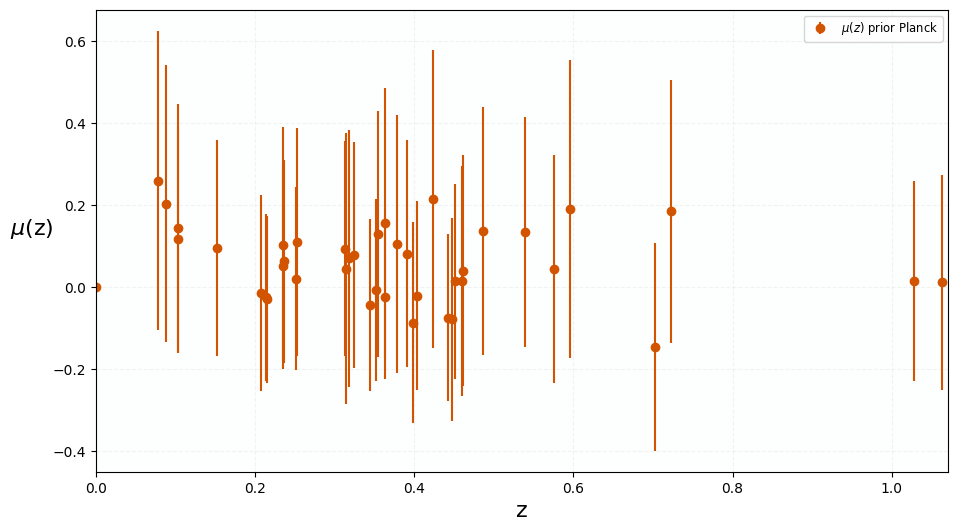

In [29]:
fig, ax = plt.subplots(figsize=(11, 6))
ax.errorbar(np.array(redshift), MU_PLANCK, yerr=err_mu, fmt="o", color="#D35400", 
            label=r'$\mu(z)$ prior Planck')
ax.grid(True, linestyle='--', alpha=0.15)
ax.set_facecolor('#FDFEFE')
ax.set_xlim(0.0, 1.071)
ax.set_xlabel('z', fontsize = '16')
ax.set_ylabel(r'$\mu$(z)', rotation=0, labelpad=15, fontsize='16')

legend_errorbar = ax.legend(loc='lower left', fontsize='small')
legend_hline = ax.legend(loc='upper right', fontsize='small')

### define variables

In [30]:
X = np.array(redshift).reshape(41,1)
Y = MU_PLANCK
X_star = np.linspace(0, 1.7, 41).reshape(41,1)

### optimize parameters (via random search)

In [31]:
def random_searchP(x, y, n): 
    best_score = -np.inf 
    best_params = None

    for _ in range(n):
        constant_value_1= np.random.uniform(1e-6, 1.5e-6)
        l = np.random.uniform(1, 4)

        kernel =C(constant_value=constant_value_1)*RBF(length_scale=l)
        model = GaussianProcessRegressor(kernel=kernel, alpha=4e-3)

        model.fit(x, y)

        score = model.score(x, y)

        if score > best_score:
            best_score = score
            best_params = { 'C1':constant_value_1, 'l':l}

    # mse
    y_pred = model.predict(x)
    mse = mean_squared_error(y, y_pred)
    
    print("Erro Quadrado Médio:", mse)                       
    return best_params, best_score


In [32]:
# define number of iterations
n_int = 250

In [33]:
best_params_PLANCK, best_score_PLANCK = random_searchP(X,Y, n_int)

Erro Quadrado Médio: 0.007793860530448385


In [34]:
print("Melhores parâmetros encontrados para PLANCK:\n")
for key, value in best_params_PLANCK.items():
    print(f"{key}: {value:.4f}")
print("")
print("Best score para PLANCK:\n")
print(f"{best_score_PLANCK:.4f}")

Melhores parâmetros encontrados para PLANCK:

C1: 0.0000
l: 3.7723

Best score para PLANCK:

0.7765


In [35]:
constant1_PLANCK = best_params_PLANCK['C1']
l_PLANCK = best_params_PLANCK['l']

###  model fit

In [36]:
# define kernel
kernel_PLANCK =  C(constant_value=constant1_PLANCK)* RBF(length_scale=l_PLANCK)

In [37]:
# generate gaussian process regressor
muGPR_PLANCK = GaussianProcessRegressor(kernel=kernel_PLANCK, alpha=1e-4, normalize_y=True)

In [38]:
# model fit
muGPR_PLANCK.fit(X, Y)

GaussianProcessRegressor(alpha=0.0001,
                         kernel=0.00108**2 * RBF(length_scale=3.77),
                         normalize_y=True)

### model predict

In [39]:
Y_pred_PLANCK, std_PLANCK = muGPR_PLANCK.predict(X_star, return_std=True)

In [40]:
mu_pred_z_0 = Y_pred_PLANCK[0]
std_mu_pred_z_0 = std_PLANCK[0]

print("Valor previsto de mu para z=0:", mu_pred_z_0)
print("Erro associado ao valor previsto de mu para z=0:", std_mu_pred_z_0)

Valor previsto de mu para z=0: 0.0005500584842369621
Erro associado ao valor previsto de mu para z=0: 0.0008950460534388555


### plot results

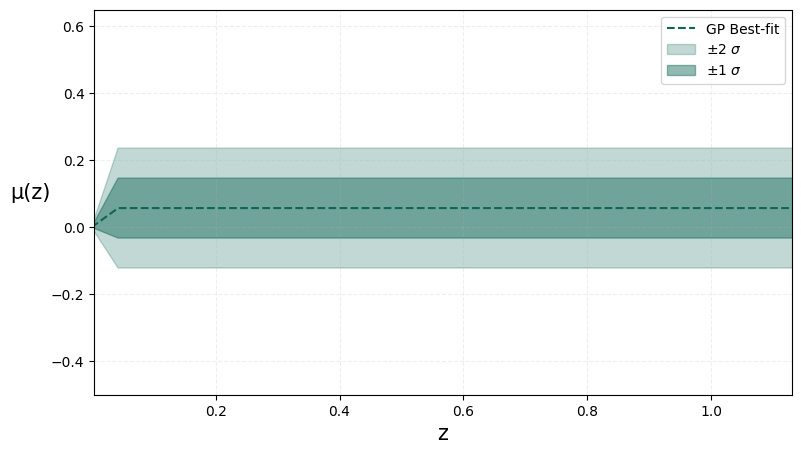

In [41]:
fig, ax = plt.subplots(figsize=(9, 5))
# plt.errorbar(np.array(redshift), MU_PLANCK, yerr=err_mu, fmt="o", color="#D35400")
plt.plot(X_star, Y_pred_PLANCK, color='#0E6655', linestyle='dashed',
         label='GP Best-fit')
ax.grid(True, linestyle='--', alpha=0.2)
plt.fill_between(X_star.flatten(), 
                 Y_pred_PLANCK - 2 * std_PLANCK, Y_pred_PLANCK + 2 * std_PLANCK, color='#0E6655', 
                 alpha=0.25, label=r'±2 $\sigma$')
plt.fill_between(X_star.flatten(), 
                Y_pred_PLANCK - std_PLANCK, Y_pred_PLANCK + std_PLANCK, color='#0E6655', 
              alpha=0.45, label=r'±1 $\sigma$')
plt.xlim(0.004, 1.13)
plt.ylim(-0.5, 0.65)


plt.xlabel('z', fontsize=15)
plt.ylabel('μ(z)', rotation=0, labelpad=15, fontsize=15)
plt.legend()
plt.savefig("reconstrução.pdf")
plt.show()

## MCMC for 2HDMLS parameters

In [42]:
z = np.linspace(0, 14, 1500).reshape(-1,1)

In [43]:
mu_GPR, std_mu_GPR = muGPR_PLANCK.predict(z, return_std=True)

In [44]:
Z_score = (np.abs(1/1837 - mu_GPR[0] ))/std_mu_GPR[0]
print("O valor de μ₀ calculado pelo GPR:",mu_GPR[0], "com erro:", std_mu_GPR[0],  
      "\n"+"está de acordo com a medida dentro de", round(Z_score,3), "σ")

O valor de μ₀ calculado pelo GPR: 0.0005500584842369621 com erro: 0.0008950460534388555 
está de acordo com a medida dentro de 0.006 σ


## Sanity check:

we can test our $\mu_{0}$ obtained by our GPR is in agreement with the m_{e} :

In [45]:
mp*mu_GPR[0]

np.float64(0.0005159548582142705)

$m_e \sim 0.5$  MeV

### MCMC for the distributions of values: $y_{e}$, $v_{2}$ and $cot\beta$

$$
\mu(z) - \frac{y_{e}}{\sqrt{2}}\frac{v_{2}}{m_{p}}cot\beta(z) = 0
$$


Subjected to (at $\mu(z=0) = \mu_{0} $)
$$
v_2^{2} + v_{1}^{2} = v_{2}^{2}( 1 + cot\beta(z=0)^{2} ) = 246^{2} 
$$

$$
(1 + cot\beta^{2}) = \frac{246^{2}}{v_{2}^{2}}
$$

In [53]:
np.random.seed(42) 

mp = 0.938
mu0 = mu_GPR[0]
sigma = 8e-4


def objetivo(y_e, v2, cot_beta, mp, mu0):
    termo1 = mu0
    termo2 = (y_e * v2*cot_beta) / (np.sqrt(2) * mp)
    return termo1 - termo2


def log_likelihood(theta, mu_GPR, sigma, mp, mu0):
    """
    Log-Likelihood considerando apenas o ponto z = 0.
    
    Parameters:
    - theta: Parâmetros (y_e, v2, cot_beta)
    - mu_GPR: Valor do processo gaussiano em z = 0
    - sigma: Incerteza associada ao valor de mu_GPR
    - mp: Constante (massa do próton)
    - mu0: Valor central mu_0 (referência)
    
    Returns:
    - log-likelihood
    """
    y_e, v2, cot_beta = theta
    modelo = objetivo(y_e, v2, cot_beta, mp, mu0)  # mu_0(0)
    residual = (mu_GPR - modelo) / sigma
    log_norm = -0.5 * np.log(2 * np.pi * sigma**2)
    log_exp = -0.5 * residual**2
    return log_norm + log_exp


def log_prior(theta):
    """
    Prior para os parâmetros.
    """
    y_e, v2, cot_beta = theta
    v2_calculado = 246 / np.sqrt(1 + cot_beta**2)
    if 0 < y_e < 1e-2 and 0 < v2 < 245.5 and np.abs(v2 - v2_calculado) < 1e-2:
        return 0.0  
    return -np.inf 


def log_posterior(theta, mu_GPR, sigma, mp, mu0):
    """
    Log-posterior combinando prior e likelihood.
    """
    lp = log_prior(theta)
    if np.isfinite(lp):
        return lp + log_likelihood(theta, mu_GPR, sigma, mp, mu0)
    return -np.inf  


nwalkers = 700
ndim = 3

# Inicializando
pos = [
    np.array([
        1.e-3,               
        np.random.normal(240.5, 4),
        1/50
    ]) + 1e-4*np.random.randn(ndim)
    for i in range(nwalkers)
]

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(mu0, sigma, mp, mu0))

sampler.run_mcmc(pos, 15000, progress=True)

samples_burn_in = sampler.get_chain(discard=4000, thin=10, flat=True)

y_e_best, v2_best, cot_beta_best = np.median(samples_burn_in, axis=0)

100%|██████████| 15000/15000 [00:43<00:00, 341.49it/s]


In [54]:
acceptance_fraction = sampler.acceptance_fraction
print(f"Taxa de aceitação média: {np.mean(acceptance_fraction)}")

corr_matrix = np.corrcoef(samples_burn_in.T)
print("Matriz de correlação entre os parâmetros:")
print(corr_matrix)

print(f"Total de amostras após o burn-in: {samples_burn_in.shape[0]}")

Taxa de aceitação média: 0.0
Matriz de correlação entre os parâmetros:
[[ 1.         -0.01070444  0.02070381]
 [-0.01070444  1.          0.01267229]
 [ 0.02070381  0.01267229  1.        ]]
Total de amostras após o burn-in: 770000


In [56]:
print(f"Melhor estimativa para y_e: {y_e_best:.4e}")
print(f"Melhor estimativa para v2: {v2_best:.4e}")
print(f"Melhor estimativa para cot_beta: {cot_beta_best:.4e}")

erros_y = np.abs(samples_burn_in[:, 0] - y_e_best)
erros_v2 = np.abs(samples_burn_in[:, 1] - v2_best)
erros_cot_beta = np.abs(samples_burn_in[:, 2] - cot_beta_best)

print("\nErros Médios:\n")
print(f"Erro Médio para y_e: {np.mean(erros_y):.4e}")
print(f"Erro Médio para v2: {np.mean(erros_v2):.4e}")
print(f"Erro Médio para cot_beta: {np.mean(erros_cot_beta):.4e}")

Melhor estimativa para y_e: 1.0055e-03
Melhor estimativa para v2: 2.4063e+02
Melhor estimativa para cot_beta: 2.0002e-02

Erros Médios:

Erro Médio para y_e: 7.8967e-05
Erro Médio para v2: 2.9341e+00
Erro Médio para cot_beta: 8.1485e-05


In [57]:
import json

y_e_nome_do_arquivo = "samples_y_e.json"
v2_nome_do_arquivo = "samples_v2.json"
cot_beta_nome_do_arquivo = "samples_cot_beta.json"

samples_y_e = samples_burn_in[:, 0].tolist()
samples_v2 = samples_burn_in[:, 1].tolist()
samples_cot_beta = samples_burn_in[:, 2].tolist()


with open(y_e_nome_do_arquivo, 'w') as f:
    json.dump(samples_y_e, f)

with open(v2_nome_do_arquivo, 'w') as f:
    json.dump(samples_v2, f)

with open(cot_beta_nome_do_arquivo, 'w') as f:
    json.dump(samples_cot_beta, f)

### plot results

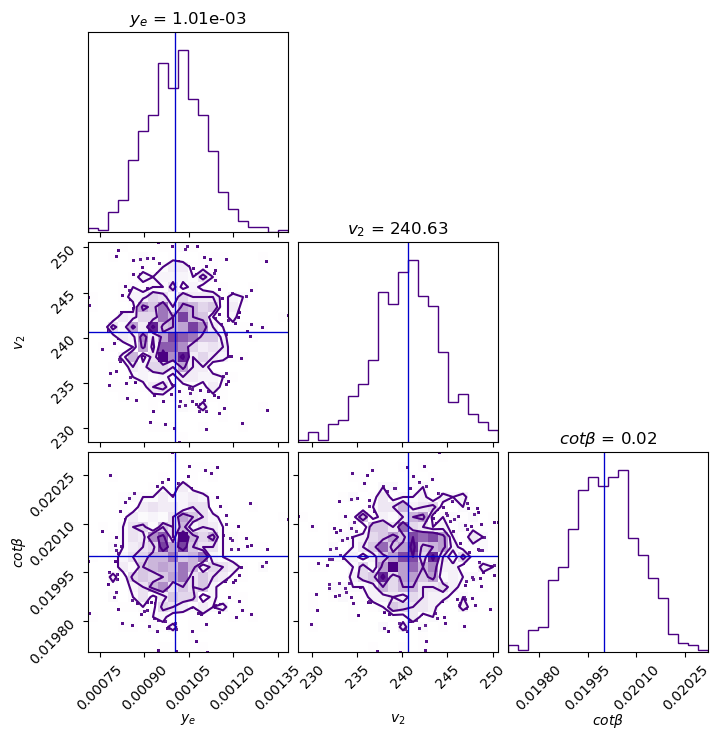

In [58]:
import corner
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df = pd.DataFrame({
    'y_e': samples_y_e,
    'v2': samples_v2,
    'cot_beta': samples_cot_beta
})

y_e_best, v2_best, cot_beta_best = np.median(samples_burn_in, axis=0)

figure = corner.corner(df, labels=[r'$y_{e}$', r'$v_{2}$', r'$cot\beta$'], hist_bin_factor=1, color='#4B0082')

axes = np.array(figure.axes).reshape((3, 3))

axes[0, 0].set_title(r'$y_{e}$ = ' + '{:.2e}'.format(y_e_best))
axes[0, 0].axvline(x=y_e_best, color='#0000CD', lw=0.96)

axes[1, 1].set_title(r'$v_{2}$ = ' + str(round(v2_best, 3)))
axes[1, 0].axvline(x=y_e_best, color='#0000CD', lw=0.96)
axes[1, 0].axhline(y=v2_best, color='#0000CD', lw=0.96)
axes[1, 1].axvline(x=v2_best, color='#0000CD', label='axvline - full height', lw=0.96)

axes[2, 0].axvline(x=y_e_best, color='#0000CD', lw=0.96)
axes[2, 0].axhline(y=cot_beta_best, color='#0000CD', lw=0.96)
axes[2, 1].axvline(x=v2_best, color='#0000CD', lw=0.96)
axes[2, 1].axhline(y=cot_beta_best, color='#0000CD', lw=0.96)

axes[2, 2].set_title(r'$cot\beta$ = ' + str(round(cot_beta_best, 5)))
axes[2, 2].axvline(x=cot_beta_best, color='#0000CD', lw=0.96)

plt.savefig("dist_con_best_values.png")
plt.show()

## In case we fix $y_{e}$

One may argue that 

$$
m_{e} = y_{e} \frac{v}{\sqrt{2}}
$$
which implies 
$$
y_e = \frac{\sqrt{2} \times 0.511 \times 10^{-3} \, \text{GeV}}{246 \, \text{GeV}}
$$

so for $v = 246.22 \pm 0.02$ GeV and $ m_{e} = 0.5109989461 \pm 3.1\cdot 10^{-9}\,$ MeV 

$$
y_{e} \approx 2.9\cdot 10^{-3} \pm 2.4 \cdot 10^{-7}
$$

one can see that in case we fix $y_{e}$ as the SM value or even the $y_{e}$ as the best value of our MCMC obtained above the results do not change much.

In [59]:
import emcee
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad

np.random.seed(42)
# y_e_fixado = 2.9e-3 # SM Value
y_e_fixado = 1.06e-2  # fixed by best value from MCMC
mp_caso_fixado = 0.938
mu0_caso_fixado = mu_GPR[0]  # mu_GPR

def objetivo_caso_fixado(v2_caso_fixado, cot_beta_caso_fixado, mp_caso_fixado, mu0_caso_fixado, y_e):
    termo1_caso_fixado = mu0_caso_fixado
    termo2_caso_fixado = (y_e * v2_caso_fixado * cot_beta_caso_fixado) / (np.sqrt(2) * mp_caso_fixado)
    return termo1_caso_fixado - termo2_caso_fixado

def log_likelihood_caso_fixado(theta_caso_fixado, mp_caso_fixado, mu0_caso_fixado, y_e):
    v2_caso_fixado, cot_beta_caso_fixado = theta_caso_fixado
    modelo_caso_fixado = objetivo_caso_fixado(v2_caso_fixado, cot_beta_caso_fixado, mp_caso_fixado, mu0_caso_fixado, y_e)
    return -0.5 * np.sum((modelo_caso_fixado - 0) ** 2)

def log_prior_caso_fixado(theta_caso_fixado):
    v2_caso_fixado, cot_beta_caso_fixado = theta_caso_fixado
    v2_calculado_caso_fixado = 246 / np.sqrt(1 + cot_beta_caso_fixado**2)
    if 0 < v2_caso_fixado < 246 and np.abs(v2_caso_fixado - v2_calculado_caso_fixado) < 1e-3:
        return 0.0
    return -np.inf

def log_posterior_caso_fixado(theta_caso_fixado, mp_caso_fixado, mu0_caso_fixado, y_e):
    lp_caso_fixado = log_prior_caso_fixado(theta_caso_fixado)
    if np.isfinite(lp_caso_fixado):
        return lp_caso_fixado + log_likelihood_caso_fixado(theta_caso_fixado, mp_caso_fixado, mu0_caso_fixado, y_e)
    return -np.inf

nwalkers_caso_fixado = 500
ndim_caso_fixado = 2

pos_caso_fixado = [np.array([240, 0.02]) + 5e-2 * np.random.randn(ndim_caso_fixado) for i in range(nwalkers_caso_fixado)]


sampler_caso_fixado = emcee.EnsembleSampler(nwalkers_caso_fixado, ndim_caso_fixado, 
                                            log_posterior_caso_fixado, args=(mp_caso_fixado, mu0_caso_fixado, y_e_fixado))

sampler_caso_fixado.run_mcmc(pos_caso_fixado, 9000, progress=True)

samples_burn_in_caso_fixado = sampler_caso_fixado.get_chain(discard=4000, flat=True)

v2_best_caso_fixado, cot_beta_best_caso_fixado = np.median(samples_burn_in_caso_fixado, axis=0)


100%|██████████| 9000/9000 [00:18<00:00, 474.36it/s]


In [60]:
print(f"Melhor v2: {v2_best_caso_fixado:.3f}")
print(f"Melhor cot_beta: {cot_beta_best_caso_fixado:.3f}")
erros_cot_beta_fixado = np.abs(samples_burn_in_caso_fixado[:, 1] - cot_beta_best_caso_fixado)
print("\nErros Médios:\n")
print(f"Erro Médio para cot_beta: {np.mean(erros_cot_beta_fixado):.6e}")

Melhor v2: 240.001
Melhor cot_beta: 0.021

Erros Médios:

Erro Médio para cot_beta: 4.495449e-02


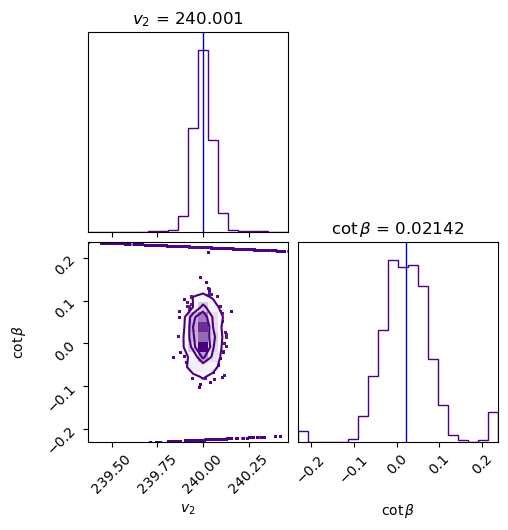

In [61]:
samples_v2_caso_fixado = samples_burn_in_caso_fixado[:, 0].tolist()
samples_cot_beta_caso_fixado = samples_burn_in_caso_fixado[:, 1].tolist()

v2_name = "samples_v2_fixado.json"
cot_beta_name = "samples_cot_beta_fixado.json"

with open(v2_name, 'w') as f:
    json.dump(samples_v2_caso_fixado, f)

with open(cot_beta_name, 'w') as f:
    json.dump(samples_cot_beta_caso_fixado, f)

df_caso_fixado = pd.DataFrame({'v2_caso_fixado': samples_v2_caso_fixado, 'cot_beta_caso_fixado': samples_cot_beta_caso_fixado})

figure_caso_fixado = corner.corner(df_caso_fixado, labels=[r'$v_2$', r'$\cot\beta$'], hist_bin_factor=1, color='#4B0082')

axes_caso_fixado = np.array(figure_caso_fixado.axes).reshape((2, 2))

v2_best_caso_fixado, cot_beta_best_caso_fixado = np.median(df_caso_fixado, axis=0)

axes_caso_fixado[0, 0].axvline(x=v2_best_caso_fixado, color='#0000CD', lw=1)
axes_caso_fixado[1, 1].axvline(x=cot_beta_best_caso_fixado, color='#0000CD', lw=1)

axes_caso_fixado[0, 0].set_title(f'$v_2$ = {v2_best_caso_fixado:.3f}')
axes_caso_fixado[1, 1].set_title(f'$\cot\\beta$ = {cot_beta_best_caso_fixado:.5f}')

plt.show()